In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.linalg import expm, logm
from numpy.linalg import matrix_power

#setup autoreload
%load_ext autoreload
%autoreload 2

In [2]:
SigX = np.array([[0, 1], [1, 0]])
SigY = np.array([[0, -1j], [1j, 0]])
SigZ = np.array([[1, 0], [0, -1]])
SigI = np.eye(2)

def commutator(A, B):
    return A @ B - B @ A

check_commutator = lambda A, B: np.allclose(commutator(A, B), 0)

PauliBasis_1Q = [SigI, SigX, SigY, SigZ]
PauliBasis_2Q = [np.kron(A, B) for A in PauliBasis_1Q for B in PauliBasis_1Q]

In [3]:
def su4_from_vector(x):
    H = np.zeros((4, 4), dtype=np.complex128)
    for idx in range(15):
        H += x[idx] * PauliBasis_2Q[idx+1]
    return H

def SU4_from_vector(x):
    return expm(-(1j/2) * su4_from_vector(x))

def vector_from_su4(H):
    coefs = np.array([np.trace(H @ P)/4 for P in PauliBasis_2Q[1:]])
    assert coefs.imag.max() < 1e-10
    return coefs.real

def vector_from_SU4(U):
    return vector_from_su4(2j * logm(U))

In [4]:
def parse_su4_vector(x):
    return {
        'IX': x[0],
        'IY': x[1],
        'IZ': x[2],
        'XI': x[3],
        'XX': x[4],
        'XY': x[5],
        'XZ': x[6],
        'YI': x[7],
        'YX': x[8],
        'YY': x[9],
        'YZ': x[10],
        'ZI': x[11],
        'ZX': x[12],
        'ZY': x[13],
        'ZZ': x[14],
    }

def idx_to_pauli_string(idx):
    return ['I', 'X', 'Y', 'Z'][idx//4] + ['I', 'X', 'Y', 'Z'][idx%4]

def plot_su4_vector(x):
    plt.bar(parse_su4_vector(x).keys(), parse_su4_vector(x).values())

In [5]:
idx_to_pauli_string(3)

'IZ'

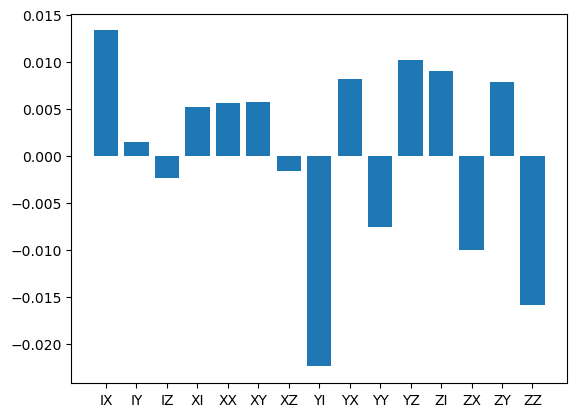

In [6]:
x = 0.01*np.random.randn(15)
U = SU4_from_vector(x)
plot_su4_vector(x)

3.157244383156457e-18


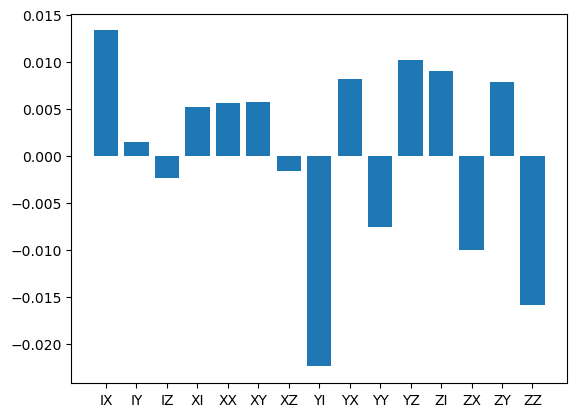

In [7]:
H = su4_from_vector(x)
xhat_su4 = vector_from_su4(H)
plot_su4_vector(xhat_su4)
print(np.linalg.norm(x - xhat_su4))

5.190500562163355e-16


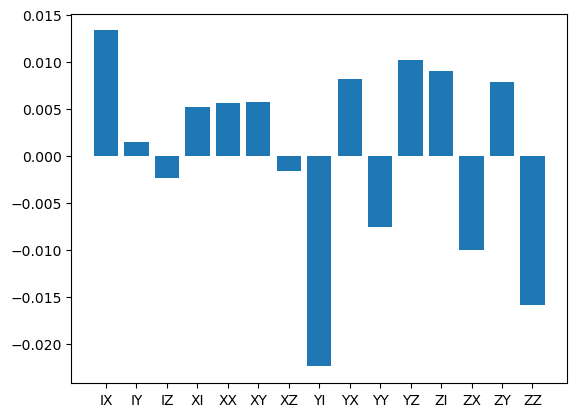

In [8]:
xhat_SU4 = vector_from_SU4(U)
plot_su4_vector(xhat_SU4)
print(np.linalg.norm(x - xhat_SU4))


# Unitary Pauli gate models

In [9]:
U_IX = np.kron(SigI, SigX)
U_IY = np.kron(SigI, SigY)
U_IZ = np.kron(SigI, SigZ)
U_XI = np.kron(SigX, SigI)
U_XX = np.kron(SigX, SigX)
U_XY = np.kron(SigX, SigY)
U_XZ = np.kron(SigX, SigZ)
U_YI = np.kron(SigY, SigI)
U_YX = np.kron(SigY, SigX)
U_YY = np.kron(SigY, SigY)
U_YZ = np.kron(SigY, SigZ)
U_ZI = np.kron(SigZ, SigI)
U_ZX = np.kron(SigZ, SigX)
U_ZY = np.kron(SigZ, SigY)
U_ZZ = np.kron(SigZ, SigZ)

# Adjoint projector definition

In [10]:
def make_Adjoint_SU4(U):
    lop = np.zeros((15, 15), dtype=complex)
    for i, op_i in enumerate(PauliBasis_2Q[1:]):
        for j, op_j in enumerate(PauliBasis_2Q[1:]):
            lop[i, j] = np.trace(op_i @ U @ op_j @ np.linalg.inv(U))/4
    return lop.real

def find_adjoint_order(Ad):
    # find the first power of the adjoint that is the identity
    for i in range(1, 100):
        if np.allclose(matrix_power(Ad, i), np.eye(15)):
            return i
    raise ValueError("Adjoint order not found")
    return None

def make_Adjoint_projector(U):
    Ad = make_Adjoint_SU4(U)
    order = find_adjoint_order(Ad)
    Pi = np.zeros((15, 15), dtype=float)
    for i in range(order):
        Pi += matrix_power(Ad, i)
    return Pi/order


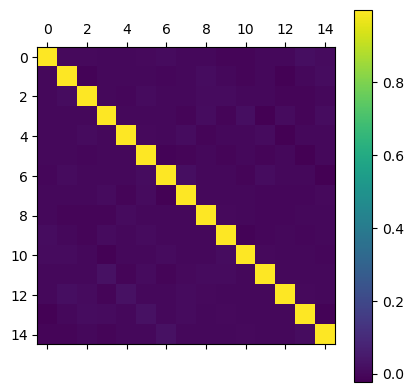

In [11]:
U = SU4_from_vector(x)
Adjoint_SU4 = make_Adjoint_SU4(U)
plt.matshow(Adjoint_SU4)
plt.colorbar()

In [12]:
pauli_Adjoints = [make_Adjoint_SU4(U) for U in PauliBasis_2Q[1:]]
pauli_orders = [find_adjoint_order(Ad) for Ad in pauli_Adjoints]
print(pauli_orders)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [13]:
projectors = [make_Adjoint_projector(U) for U in PauliBasis_2Q[1:]]

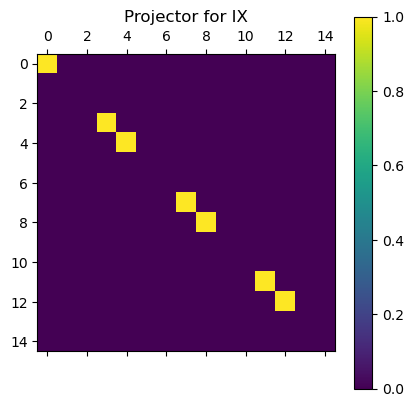

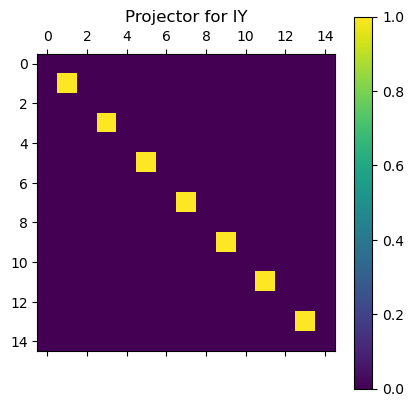

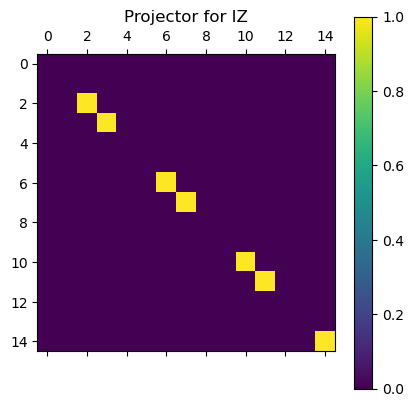

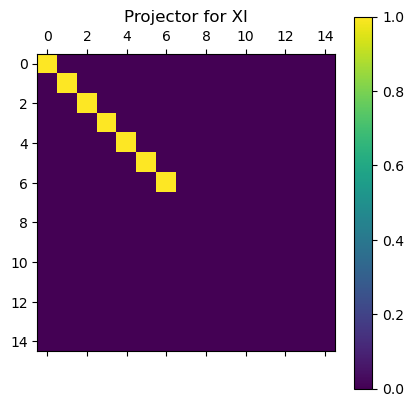

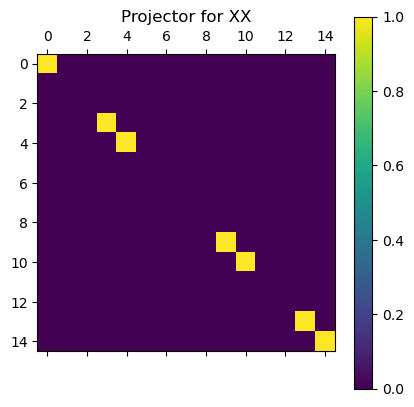

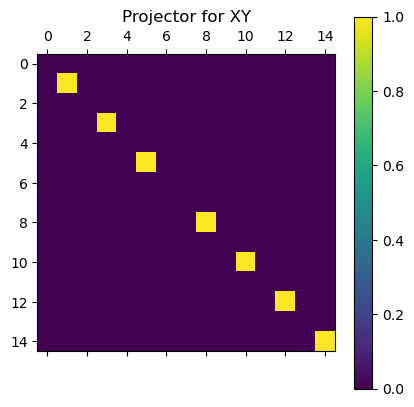

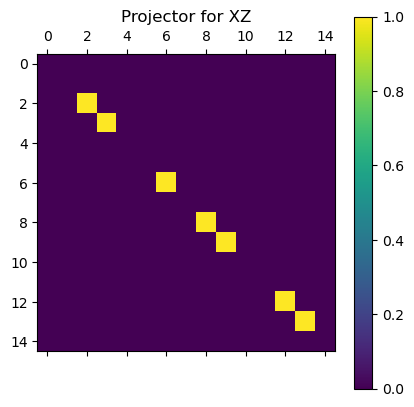

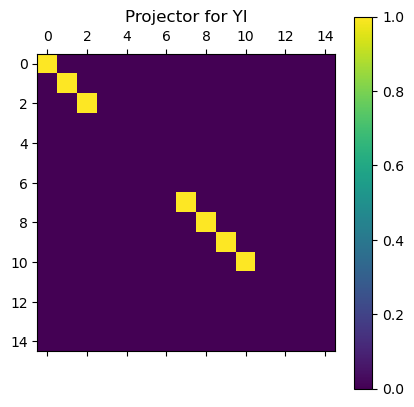

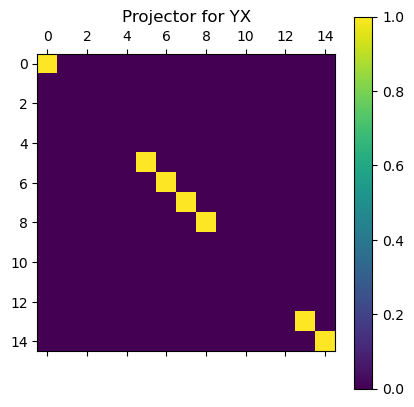

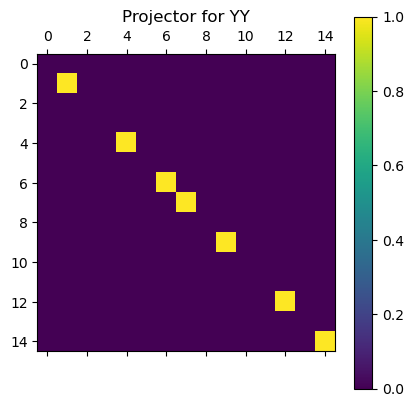

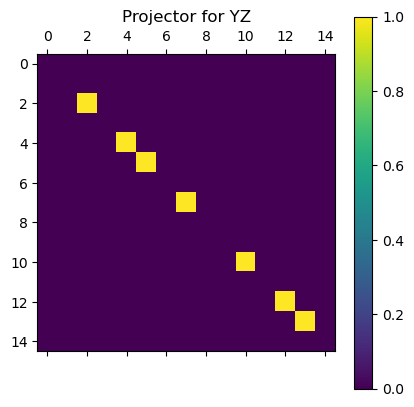

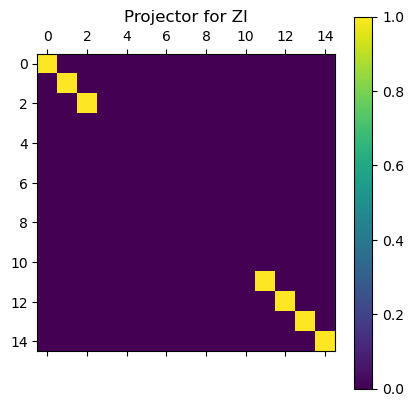

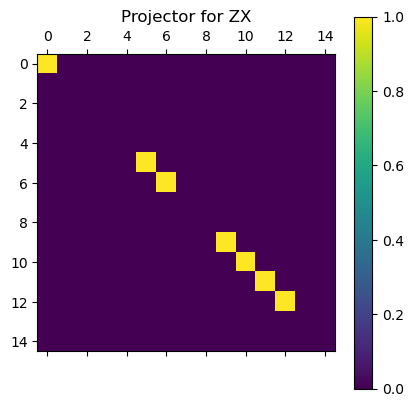

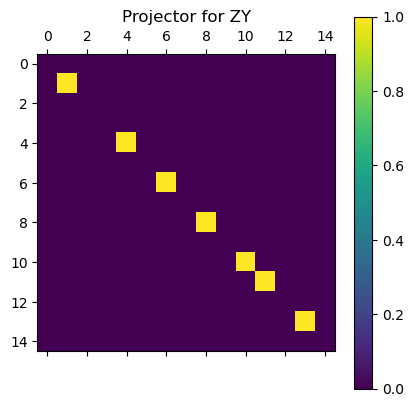

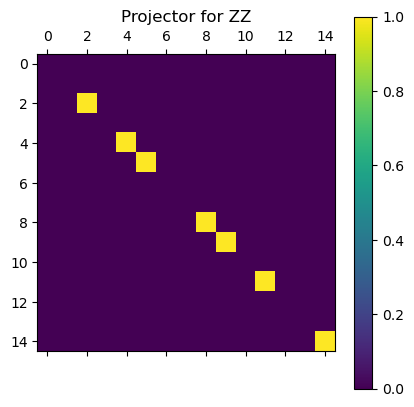

In [14]:
for idx, P in enumerate(projectors):
    pauli_string = idx_to_pauli_string(idx+1)
    plt.matshow(P)
    plt.colorbar()
    plt.title(f"Projector for {pauli_string}")
    plt.show()

In [15]:
proj_IX = projectors[0]
proj_IY = projectors[1]
proj_IZ = projectors[2]
proj_XI = projectors[3]
proj_XX = projectors[4]
proj_XY = projectors[5]
proj_XZ = projectors[6]
proj_YI = projectors[7]
proj_YX = projectors[8]
proj_YY = projectors[9]
proj_YZ = projectors[10]
proj_ZI = projectors[11]
proj_ZX = projectors[12]
proj_ZY = projectors[13]
proj_ZZ = projectors[14]


# identify projectors on each diagonal element

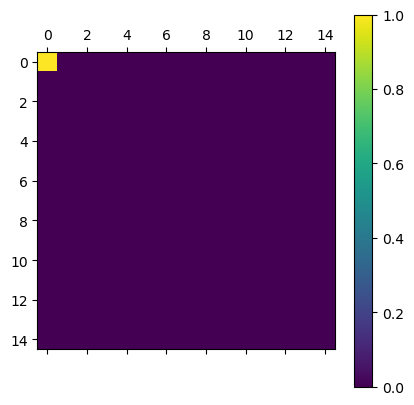

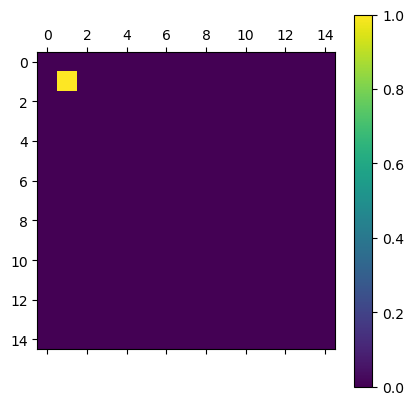

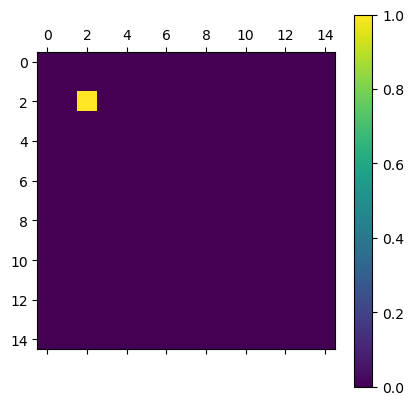

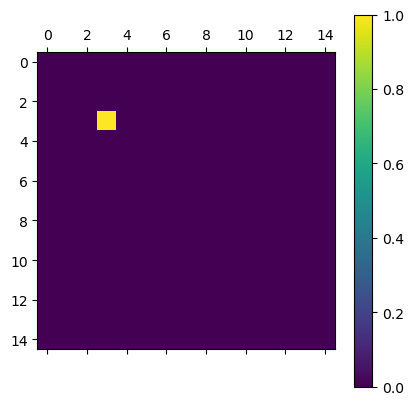

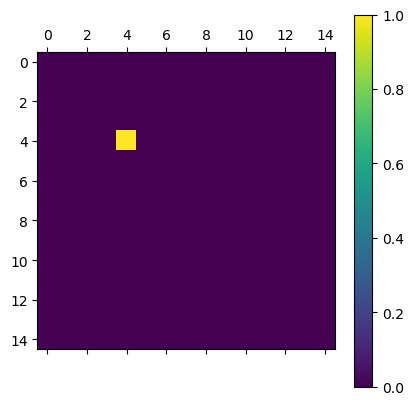

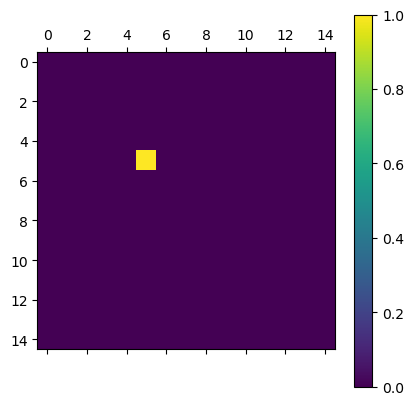

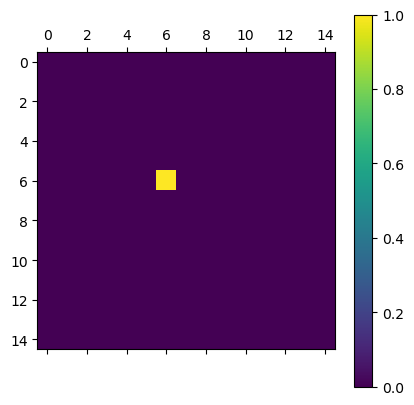

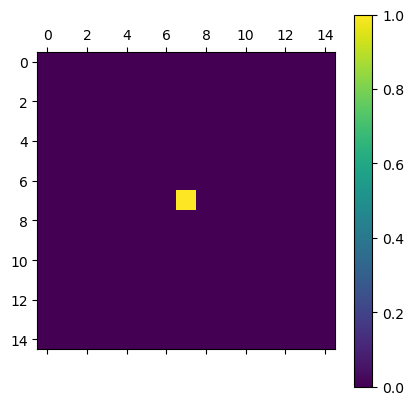

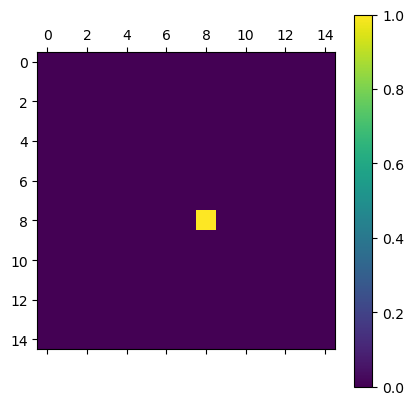

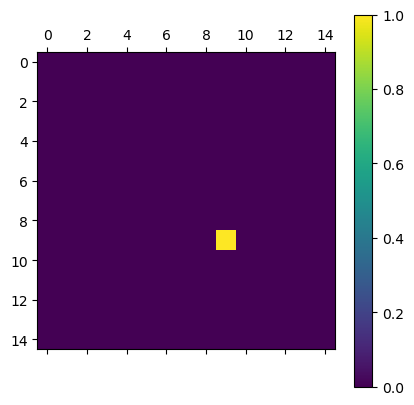

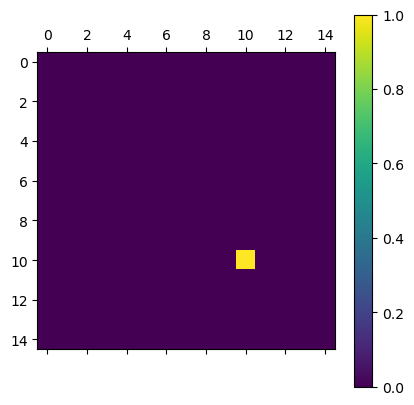

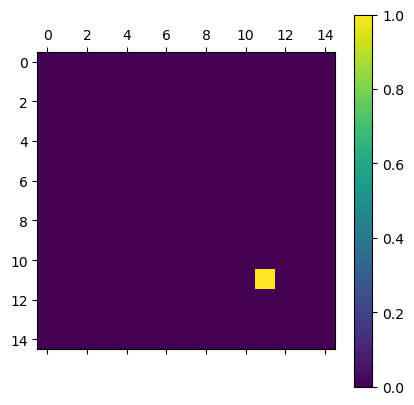

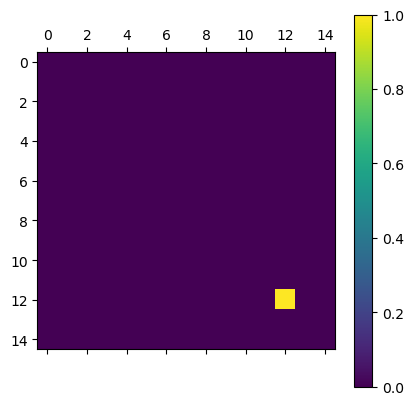

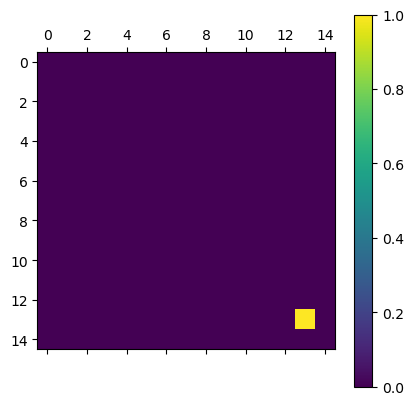

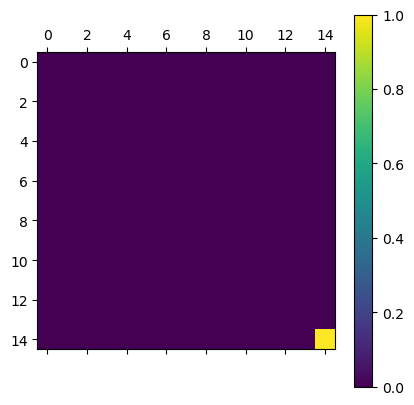

In [25]:
diag_matrix_units = [np.zeros((15, 15), dtype=float) for _ in range(15)]
for idx, P in enumerate(projectors):
    diag_matrix_units[idx][idx, idx] = 1
for idx, P in enumerate(diag_matrix_units):
    plt.matshow(P)
    plt.colorbar()

In [26]:
import itertools

In [34]:
# create triplets of the projector indices
triplets = []
for idx in range(15):
    for jdx in range(15):
        for kdx in range(15):
            if idx != jdx and idx != kdx and jdx != kdx:
                triplets.append((idx, jdx, kdx))

In [36]:
len(triplets)

2730

In [45]:
triplets_found = dict()
for t1, t2, t3 in triplets:
    P = projectors[t1] @ projectors[t2] @ projectors[t3]
    for unit in diag_matrix_units:
        if np.allclose(P, unit):
            diag_vec = np.diag(unit)
            if tuple(diag_vec) not in triplets_found:
                triplets_found[tuple(diag_vec)] = (t1, t2, t3)
            if len(triplets_found) == 15:
                break

In [47]:
len(triplets_found)

15

In [48]:
triplets_found

{(0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0): (0, 1, 3),
 (0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0): (0, 1, 7),
 (0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0): (0, 1, 11),
 (1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0): (0, 3, 7),
 (0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0): (0, 3, 9),
 (0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0): (0, 5, 7),
 (0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0): (0, 5, 9),
 (0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0): (1, 3, 7),
 (0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,


In [51]:
PauliBasis_2Q

[array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]]),
 array([[0.+0.j, 0.-1.j, 0.+0.j, 0.-0.j],
        [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.-0.j, 0.+0.j, 0.-1.j],
        [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j]]),
 array([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0., -0.],
        [ 0.,  0.,  1.,  0.],
        [ 0., -0.,  0., -1.]]),
 array([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]]),
 array([[0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0]]),
 array([[0.+0.j, 0.-0.j, 0.+0.j, 0.-1.j],
        [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j],
        [0.+0.j, 0.-1.j, 0.+0.j, 0.-0.j],
        [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[ 0,  0,  1,  0],
        [ 0,  0,  0, -1],
        [ 1,  0,  0,  0],
        [ 0, -1,  0,  0]]),
 array([[0.+0.j, 0.+0.j,

In [53]:
parse_su4_vector(list(triplets_found.keys())[0])

{'IX': 0.0,
 'IY': 0.0,
 'IZ': 0.0,
 'XI': 1.0,
 'XX': 0.0,
 'XY': 0.0,
 'XZ': 0.0,
 'YI': 0.0,
 'YX': 0.0,
 'YY': 0.0,
 'YZ': 0.0,
 'ZI': 0.0,
 'ZX': 0.0,
 'ZY': 0.0,
 'ZZ': 0.0}

In [55]:
def index_to_pauli_string(idx):
    diag_vec = np.zeros(15)
    diag_vec[idx] = 1
    parsed_dict = parse_su4_vector(diag_vec)
    return ' '.join([key for key, val in parsed_dict.items() if val != 0])

def diag_vec_to_pauli_string(diag_vec):
    return ' '.join([index_to_pauli_string(idx) for idx, val in enumerate(diag_vec) if val != 0])

for diag_vec, triplet in triplets_found.items():
    print(f"{index_to_pauli_string(triplet[0])} {index_to_pauli_string(triplet[1])} {index_to_pauli_string(triplet[2])} -> {diag_vec_to_pauli_string(diag_vec)}")

IX IY XI -> XI
IX IY YI -> YI
IX IY ZI -> ZI
IX XI YI -> IX
IX XI YY -> XX
IX XY YI -> YX
IX XY YY -> ZX
IY XI YI -> IY
IY XI YX -> XY
IY XX YI -> YY
IY XX YX -> ZY
IZ XI YI -> IZ
IZ XI YX -> XZ
IZ XX YI -> YZ
IZ XX YX -> ZZ


# make a design to measure the commutant of ZZ

Text(0.5, 1.0, 'Projector for ZZ')

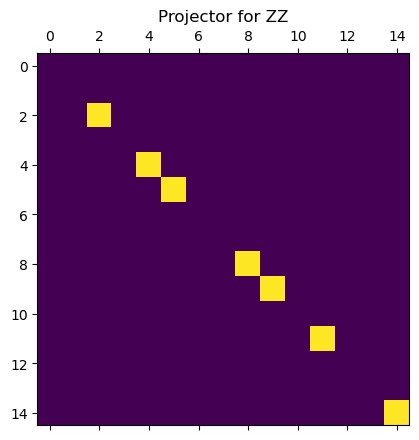

In [16]:
plt.matshow(proj_ZZ)
plt.title("Projector for ZZ")

True


Text(0.5, 1.0, 'Pi_ZZ Pi_XI')

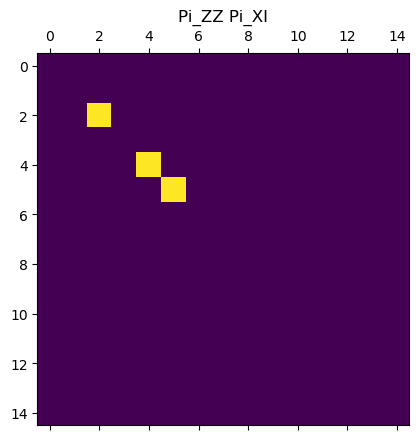

In [17]:
print(check_commutator(proj_ZZ, proj_XI))
plt.matshow(proj_ZZ@proj_XI)
plt.title("Pi_ZZ Pi_XI")

True


Text(0.5, 1.0, 'Pi_ZZ Pi_IX')

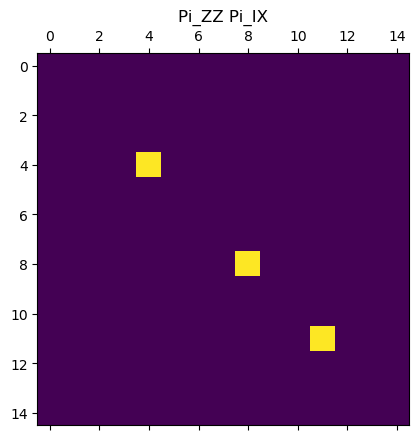

In [18]:
print(check_commutator(proj_ZZ, proj_IX))
plt.matshow(proj_ZZ@proj_IX)
plt.title("Pi_ZZ Pi_IX")

True


Text(0.5, 1.0, 'Pi_ZZ Pi_XX')

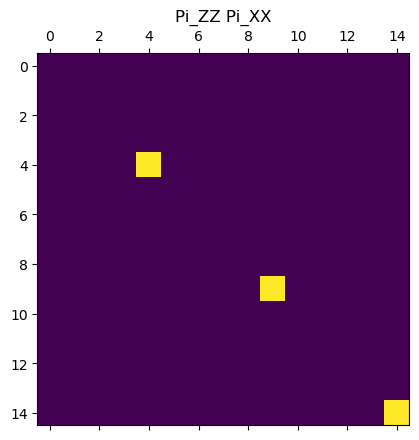

In [19]:
print(check_commutator(proj_ZZ, proj_XX))
plt.matshow(proj_ZZ@proj_XX)
plt.title("Pi_ZZ Pi_XX")

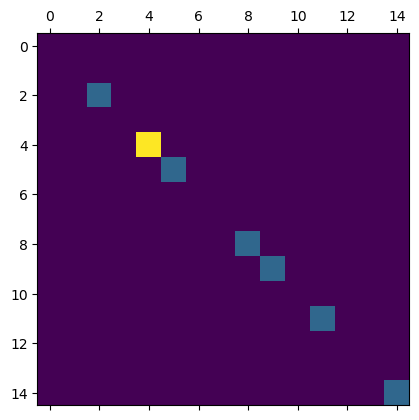

In [20]:
prod_ZZ_XI = proj_ZZ @ proj_XI
prod_ZZ_IX = proj_ZZ @ proj_IX
prod_ZZ_YY = proj_ZZ @ proj_YY
plt.matshow(prod_ZZ_XI + prod_ZZ_IX + prod_ZZ_YY)

### it has rank 7!